<a href="https://colab.research.google.com/github/1X-HE/OKOKqm2/blob/main/regression%26scatter_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OUTLIER IDENTIFICATION AND ANALYSIS
Total data points: 32
Number of outliers detected: 2
Outlier threshold: 2.5 standard deviations from regression line

OUTLIER DETAILS:
------------------------------------------------------------
Borough                        Airbnb Density       Crime Rate           Z-Score        
------------------------------------------------------------
Kensington and Chelsea         21.57                159.61               -3.51          
Westminster                    25.09                412.58               3.51           
------------------------------------------------------------

OUTLIER SUMMARY STATISTICS:
Average Airbnb density (outliers): 23.33
Average crime rate (outliers): 286.10
Average z-score (outliers): 0.00
REGRESSION ANALYSIS
Regression equation: Crime Rate = 9.8545 × Airbnb Density + 56.1285
R-squared: 0.7551

Plot saved as 'airbnb_crime_relationship_with_outliers.png'


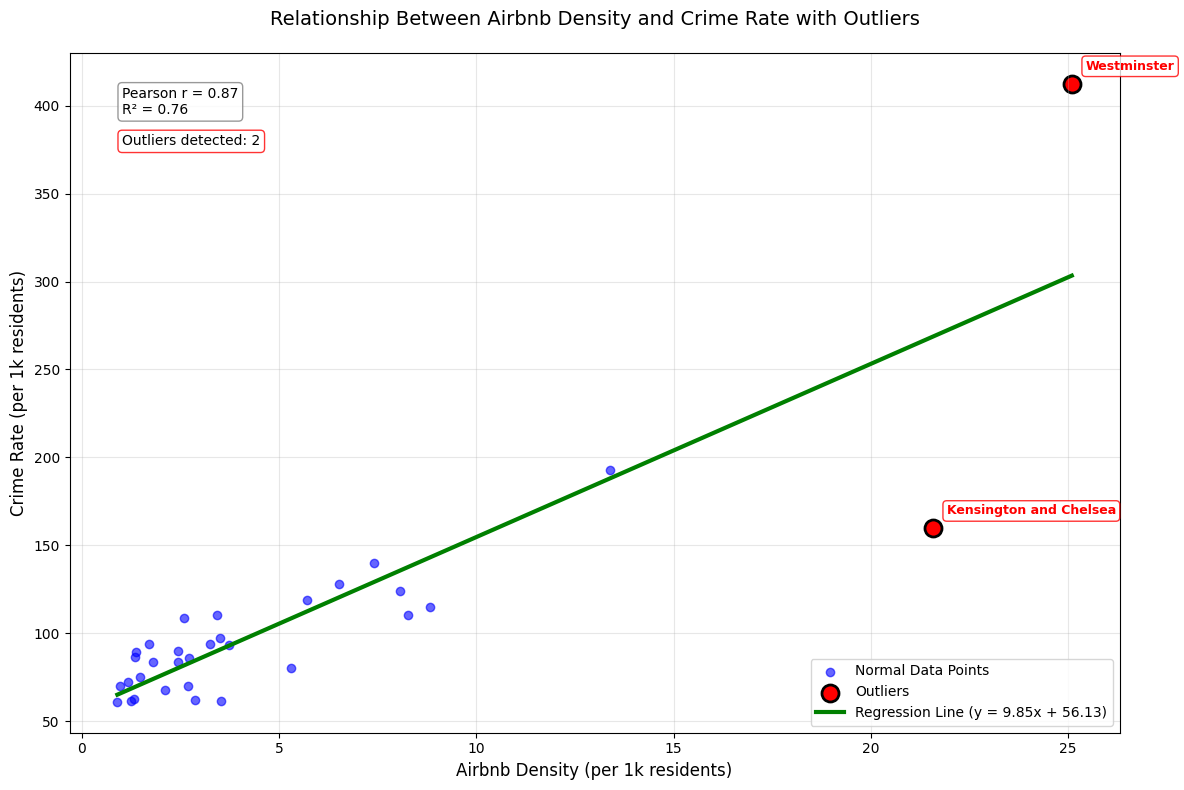

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Read the CSV file
df = pd.read_csv('borough_metrics_ons2024_per1k.csv')

# Check for required columns
required_cols = ['borough', 'crime_rate_per_1k', 'airbnb_density_per_1k']
if not all(col in df.columns for col in required_cols):
    missing = [col for col in required_cols if col not in df.columns]
    raise ValueError(f"Missing required columns: {missing}")

# Clean data - remove rows with missing values
df_clean = df[required_cols].dropna()

# Check if we have enough data for regression
if len(df_clean) < 2:
    raise ValueError("Not enough data points for regression analysis. Need at least 2 samples.")

# Prepare data for regression
X = df_clean['airbnb_density_per_1k'].values.reshape(-1, 1)
y = df_clean['crime_rate_per_1k'].values
borough_names = df_clean['borough'].values

# Perform linear regression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

# Calculate R-squared using sklearn's r2_score for consistency
r_squared = r2_score(y, y_pred)

# Calculate residuals and identify outliers
residuals = y - y_pred
z_scores = stats.zscore(residuals)
outliers_mask = np.abs(z_scores) > 2.5  # 2.5 standard deviations threshold

# Get outlier information
outlier_indices = np.where(outliers_mask)[0]
outlier_data = []

print("=" * 60)
print("OUTLIER IDENTIFICATION AND ANALYSIS")
print("=" * 60)
print(f"Total data points: {len(df_clean)}")
print(f"Number of outliers detected: {len(outlier_indices)}")
print(f"Outlier threshold: 2.5 standard deviations from regression line")
print()

# Display outlier information
if len(outlier_indices) > 0:
    print("OUTLIER DETAILS:")
    print("-" * 60)
    print(f"{'Borough':<30} {'Airbnb Density':<20} {'Crime Rate':<20} {'Z-Score':<15}")
    print("-" * 60)

    for idx in outlier_indices:
        borough = borough_names[idx]
        density = df_clean.iloc[idx]['airbnb_density_per_1k']
        crime = df_clean.iloc[idx]['crime_rate_per_1k']
        z_score = z_scores[idx]

        outlier_data.append({
            'borough': borough,
            'airbnb_density': density,
            'crime_rate': crime,
            'z_score': z_score
        })

        print(f"{borough:<30} {density:<20.2f} {crime:<20.2f} {z_score:<15.2f}")

    print("-" * 60)

    # Print summary statistics
    print("\nOUTLIER SUMMARY STATISTICS:")
    print(f"Average Airbnb density (outliers): {np.mean([od['airbnb_density'] for od in outlier_data]):.2f}")
    print(f"Average crime rate (outliers): {np.mean([od['crime_rate'] for od in outlier_data]):.2f}")
    print(f"Average z-score (outliers): {np.mean([od['z_score'] for od in outlier_data]):.2f}")
else:
    print("No outliers detected with the current threshold (|z-score| > 2.5)")
    print()
print("=" * 60)
print("REGRESSION ANALYSIS")
print("=" * 60)
print(f"Regression equation: Crime Rate = {reg.coef_[0]:.4f} × Airbnb Density + {reg.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")
print()

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(df_clean['airbnb_density_per_1k'],
            df_clean['crime_rate_per_1k'],
            c='blue',
            alpha=0.6,
            label='Normal Data Points')

# outliers
if len(outlier_indices) > 0:
    outlier_x = df_clean['airbnb_density_per_1k'].iloc[outlier_indices].values
    outlier_y = df_clean['crime_rate_per_1k'].iloc[outlier_indices].values
    outlier_names = borough_names[outlier_indices]

    plt.scatter(outlier_x, outlier_y,
                c='red',
                s=150,
                edgecolors='black',
                linewidth=2,
                label='Outliers')

    # text annotations for outliers
    for i, (x, y, name) in enumerate(zip(outlier_x, outlier_y, outlier_names)):
        plt.annotate(name,
                     xy=(x, y),
                     xytext=(10, 10),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold',
                     color='red',
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white',
                               edgecolor='red',
                               alpha=0.8))

# Regression line
x_range = np.linspace(df_clean['airbnb_density_per_1k'].min(),
                      df_clean['airbnb_density_per_1k'].max(),
                      100)
y_range_pred = reg.predict(x_range.reshape(-1, 1))

plt.plot(x_range, y_range_pred,
         color='green',
         linewidth=3,
         label=f'Regression Line (y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f})')

# labels and title
plt.xlabel('Airbnb Density (per 1k residents)', fontsize=12)
plt.ylabel('Crime Rate (per 1k residents)', fontsize=12)
plt.title('Relationship Between Airbnb Density and Crime Rate with Outliers', fontsize=14, pad=20)
plt.legend()

# correlation coefficient
corr = np.corrcoef(df_clean['airbnb_density_per_1k'], df_clean['crime_rate_per_1k'])[0, 1]
plt.text(0.05, 0.95,
         f'Pearson r = {corr:.2f}\nR² = {r_squared:.2f}',
         transform=plt.gca().transAxes,
         ha='left',
         va='top',
         fontsize=10,
         bbox=dict(boxstyle='round',
                   facecolor='white',
                   edgecolor='gray',
                   alpha=0.8))


if len(outlier_indices) > 0:
    plt.text(0.05, 0.88,
             f'Outliers detected: {len(outlier_indices)}',
             transform=plt.gca().transAxes,
             ha='left',
             va='top',
          fontsize=10,
             bbox=dict(boxstyle='round',
                       facecolor='white',
                       edgecolor='red',
                       alpha=0.8))

# Add grid
plt.grid(True, alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig('airbnb_crime_relationship_with_outliers.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'airbnb_crime_relationship_with_outliers.png'")
plt.show()



